In [2]:
import matplotlib.pyplot as plt

import sys
sys.path.append('.')
sys.path.append('/home/robert/git/pytorch-wavenet')
import os
import torch
import numpy as np
import util
import rans
from torch_vae.tvae_beta_binomial import BetaBinomialVAE
from torch_vae import tvae_utils
from torchvision import datasets, transforms
import time
import json

from dataset import AudioDataset
from vae import VAE, WaveNetEncoder, WaveNetDecoder

import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from scipy.special import softmax

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [14]:
pytorch_wavenet_path = "/home/robert/git/pytorch-wavenet/"

rng = np.random.RandomState(0)
np.seterr(over='raise')

prior_precision = 8
obs_precision = 14
q_precision = 14

compress_lengths = []

# latent_dim = 50
latent_shape = (1, 508)
# model = BetaBinomialVAE(hidden_dim=200, latent_dim=latent_dim)

config_file = pytorch_wavenet_path+"medium_lr3.json"
checkpoint_file = pytorch_wavenet_path+"snapshots/slow_anneal_temp_linear_classic_music_medium_lr3_500000"

with open(config_file) as f:
    data = f.read()
config = json.loads(data)
encoder_wavenet_args = config["encoder_wavenet_args"]
decoder_wavenet_args = config["decoder_wavenet_args"]
model = VAE(
    WaveNetEncoder(encoder_wavenet_args),
    WaveNetDecoder(decoder_wavenet_args),
    hard_gumbel_softmax=True
)
checkpoint_dict = torch.load(checkpoint_file, map_location='cpu')
model.load_state_dict(checkpoint_dict['model'])
model.eval();

In [15]:
dataset = AudioDataset(pytorch_wavenet_path+"wav_audio/small_wav_tensor.pt", model.encoder.wavenet.receptive_field*4)        
print('the dataset has ' + str(len(dataset)) + ' items')
print(f'each item has length {dataset.len_sample}')
print(f'The WaveNetVAE has {model.encoder.wavenet.parameter_count() + model.decoder.wavenet.parameter_count()} parameters')

the dataset has 19685 items
each item has length 508
The WaveNetVAE has 342080 parameters


In [16]:
gumbel_softmax_temperature = 1.# config['train_args']['gumbel_softmax_temperature']
x = dataset[2000].long().unsqueeze(0)

In [17]:
model.is_input_one_hot = True
p_x, q_z = model(x, .001)

In [18]:
q_z.shape

torch.Size([1, 256, 508])

In [19]:
from vae import gumbel_softmax
import matplotlib.pyplot as pl

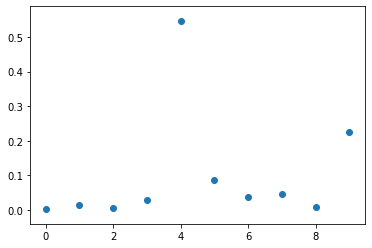

In [20]:
latent_dim = 10
r = torch.rand(1, latent_dim, 1)
plt.scatter(range(0, latent_dim), gumbel_softmax(r, temperature=.5)[0,:,0])

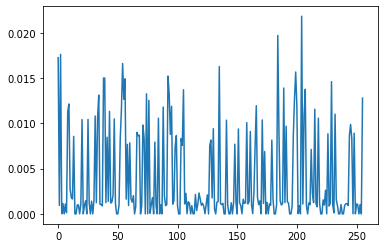

In [21]:
plt.plot(gumbel_softmax(q_z, temperature=5.)[0, :, 0].detach().numpy())

In [22]:
model.encode(x).shape

torch.Size([1, 256, 508])

In [24]:
loss = model.loss(p_x, x, q_z)
loss

tensor(2806.4075, grad_fn=<AddBackward0>)

In [25]:
x.shape

torch.Size([1, 508])

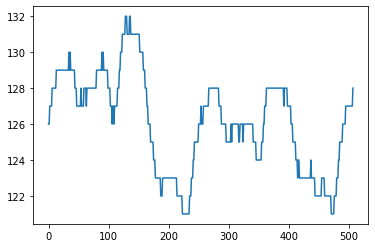

In [26]:
plt.plot(x.squeeze())

```python
def bb_ans_append(post_pop, lik_append, prior_append):
    def append(state, data):  # vae_append
        state, latent = post_pop(data)(state)
        state = lik_append(latent)(state, data)
        state = prior_append(state, latent)
        return state
    return append   # becomes vae_append

def bb_ans_pop(prior_pop, lik_pop, post_append):
    def pop(state):
        state, latent = prior_pop(state)
        state, data = lik_pop(latent)(state)
        state = post_append(data)(state, latent)
        return state, data
    return pop
```

In [155]:
def cvae_append(latent_shape, gen_net, rec_net, obs_append, prior_prec=8,
               latent_prec=14):
    """
    VAE with discrete latents, parameterized by categorical dist and
    with uniform prior
    """
    def post_pop(data):
        posterior_probs = rec_net(data.unsqueeze(0))
        print("posterior_probs.shape", posterior_probs.shape)
        return util.categoricals_pop(posterior_probs, latent_prec)

    def lik_append(latents):
        print("lik_append latents.shape", latents.shape)
        print("lik_append latents", latents)
        obs_params = gen_net(np.reshape(latents, latent_shape))
        print("obs_params.shape", obs_params.shape)
        return obs_append(obs_params)

    prior_append = util.uniforms_append(prior_prec)
    return util.bb_ans_append(post_pop, lik_append, prior_append)

def cvae_pop(
        latent_shape, gen_net, rec_net, obs_pop, prior_prec=8, latent_prec=12):
    """
    VAE with discrete latents, parameterized by categorical dist and
    with uniform prior
    """
    prior_pop = util.uniforms_pop(prior_prec, np.prod(latent_shape))

    def lik_pop(latents):
        print("lik_pop latents.shape", latents.shape)
        print("lik_pop latents", latents)
        obs_params = gen_net(np.reshape(latents, latent_shape))
        print("obs_params.shape", obs_params.shape)
        return obs_pop(obs_params)

    def post_append(data):
        print("post_append data.shape", data.shape)
        posterior_probs = rec_net(np.expand_dims(data, 0))
        print("posterior_probs.shape", posterior_probs.shape)
        return util.categoricals_append(posterior_probs, latent_prec)

    return util.bb_ans_pop(prior_pop, lik_pop, post_append)

In [156]:
model.decoder.is_input_one_hot = False

def wavenet_logits_to_probs(logits_net):
    def probs_net(data):
        logits = logits_net(data).squeeze(0).transpose(1,0)
        return softmax(logits, axis=1)
    return probs_net

rec_net = wavenet_logits_to_probs(tvae_utils.torch_fun_to_numpy_fun(model.encode))
gen_net = wavenet_logits_to_probs(tvae_utils.torch_fun_to_numpy_fun(model.decode))

# obs_append = tvae_utils.beta_binomial_obs_append(255, obs_precision)
# obs_pop = tvae_utils.beta_binomial_obs_pop(255, obs_precision)

def get_obs_append(precision):
    def obs_append(obs_params):
        return util.categoricals_append(obs_params, precision)
    return obs_append
def get_obs_pop(precision):
    def obs_pop(obs_params):
        return util.categoricals_pop(obs_params, precision)
    return obs_pop

obs_append = get_obs_append(obs_precision)
obs_pop = get_obs_pop(obs_precision)

vae_append = cvae_append(latent_shape, gen_net, rec_net, obs_append,
                             prior_precision, q_precision)
vae_pop = cvae_pop(latent_shape, gen_net, rec_net, obs_pop,
                       prior_precision, q_precision)

In [157]:
# randomly generate some 'other' bits
other_bits = rng.randint(1 << 32, size=508*10, dtype=np.uint32)
state = rans.x_init
state = util.uniforms_append(32)(state, other_bits)

In [158]:
other_bits.shape, other_bits.max(), other_bits.min(), other_bits.dtype

((5080,), 4294964600, 3072091, dtype('uint32'))

In [159]:
# ---------------------------- ENCODE ------------------------------------
x = x.squeeze()
state = vae_append(state, x)
compressed_message = rans.flatten(state)

print("Used " + str(32 * (len(compressed_message) - len(other_bits))) +
      " bits.")

posterior_probs.shape (508, 256)
lik_append latents.shape (508,)
lik_append latents [ 54  94  36  44 230 188 227 215 118 121 117  76 210  87 233 213  71 145
 228  82 189 246 165  89 168 162  33 196 124 187 188 218 106  82 230  13
  77  39 237 155 127 217  96 127 245  48 152 150 172  82 115 214 167 100
  25  11  91  65 156  54 230  92  92 217 192 245 166 198  60 145 184 243
  70  52  82  60  71  99  19 229 207  32  63 166  76  12 136  57 234  54
 164  19  72  28  35 129 232 151  37 180 160  20 216 196 224  65  70 233
 112 148  90  96  12  10 109 172   0 141  61 198  67  88  81  95   5 128
 146 226 164 138 211 146 221 146 233 133 100  56  96  93  86  42  32   6
  32 129 207  62 161 166  84  31 218 159 158 207 215  35 188 242  13 220
  20  17  91 180   8 215   2 185  65 234  70 168  97  22 164 134 246  99
 158 162 136  47 169  74   2 180 126 150 215  79 185 190  90  66 136 222
 233 169  45 253  90 138 160  74  17 182  70 186 133 148  35 228  57 126
 248 188 198 150 193 150 245  89 168 157

In [160]:
# ---------------------------- DECODE ------------------------------------
state = rans.unflatten(compressed_message)

state, x_ = vae_pop(state)
# assert all(x == x_)
x[0:10], x_[0:10]

lik_pop latents.shape (508,)
lik_pop latents [ 54  94  36  44 230 188 227 215 118 121 117  76 210  87 233 213  71 145
 228  82 189 246 165  89 168 162  33 196 124 187 188 218 106  82 230  13
  77  39 237 155 127 217  96 127 245  48 152 150 172  82 115 214 167 100
  25  11  91  65 156  54 230  92  92 217 192 245 166 198  60 145 184 243
  70  52  82  60  71  99  19 229 207  32  63 166  76  12 136  57 234  54
 164  19  72  28  35 129 232 151  37 180 160  20 216 196 224  65  70 233
 112 148  90  96  12  10 109 172   0 141  61 198  67  88  81  95   5 128
 146 226 164 138 211 146 221 146 233 133 100  56  96  93  86  42  32   6
  32 129 207  62 161 166  84  31 218 159 158 207 215  35 188 242  13 220
  20  17  91 180   8 215   2 185  65 234  70 168  97  22 164 134 246  99
 158 162 136  47 169  74   2 180 126 150 215  79 185 190  90  66 136 222
 233 169  45 253  90 138 160  74  17 182  70 186 133 148  35 228  57 126
 248 188 198 150 193 150 245  89 168 157  12 115 122 106 222  74 187  11
 241  

(tensor([126, 126, 127, 127, 127, 127, 128, 128, 128, 128]),
 array([126, 126, 127, 127, 127, 127, 128, 128, 128, 128]))

In [131]:
#  recover the other bits from q(y|x_0)
state, recovered_bits = util.uniforms_pop(32, other_bits.shape[0])(state)
assert all(other_bits == recovered_bits)
assert state == rans.x_init

# MNIST Business

In [41]:
num_images = 100
# load some mnist images
mnist = datasets.MNIST('data/mnist', train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))
images = mnist.test_data[:num_images]

images = [image.float().view(1, -1) for image in images]

In [44]:
images[0].shape, len(images), images[0].min(), images[0].max()

(torch.Size([1, 784]), 100, tensor(0.), tensor(255.))

In [45]:
# randomly generate some 'other' bits
other_bits = rng.randint(low=1 << 16, high=1 << 31, size=508*2, dtype=np.uint32)
state = rans.unflatten(other_bits)

In [57]:
dataset[0:10].shape

torch.Size([10, 508])

In [12]:
print_interval = 10
encode_start_time = time.time()
for i, image in enumerate(images):
    state = vae_append(state, image)

    if not i % print_interval:
        print('Encoded {}'.format(i))

    compressed_length = 32 * (len(rans.flatten(state)) - len(other_bits)) / (i+1)
    compress_lengths.append(compressed_length)

print('\nAll encoded in {:.2f}s'.format(time.time() - encode_start_time))
compressed_message = rans.flatten(state)

Encoded 0
Encoded 10
Encoded 20
Encoded 30
Encoded 40
Encoded 50
Encoded 60
Encoded 70
Encoded 80
Encoded 90

All encoded in 25.42s


In [ ]:
compressed_bits = 32 * (len(compressed_message) - len(other_bits))
print("Used " + str(compressed_bits) + " bits.")
print('This is {:.2f} bits per pixel'.format(compressed_bits
                                             / (num_images * 784)))
print(f"This is a compression factor of {(num_images * 784 * 8) / compressed_bits}")

if not os.path.exists('results'):
    os.mkdir('results')
np.savetxt('compressed_lengths_cts', np.array(compress_lengths))

state = rans.unflatten(compressed_message)
decode_start_time = time.time()

for n in range(len(images)):
    state, image_ = vae_pop(state)
    original_image = images[len(images)-n-1].numpy()
    np.testing.assert_allclose(original_image, image_)

    if not n % print_interval:
        print('Decoded {}'.format(n))

print('\nAll decoded in {:.2f}s'.format(time.time() - decode_start_time))

recovered_bits = rans.flatten(state)
assert all(other_bits == recovered_bits)

Used 105504 bits.
This is 1.35 bits per pixel
This is a compression factor of 5.944798301486199
Decoded 0
Decoded 10
Decoded 20
Decoded 30
